In [1]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import mdmm

import zuko
from zuko.flows import Flow, UnconditionalDistribution, UnconditionalTransform
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.distributions import DiagNormal
from zuko.transforms import RotationTransform

# Learning the conditional probability of the generator level event boost

In [9]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in [ "x1x2_data", "EcmPz_data","EcmPz_reco_data","EcmPz_data_original","EcmPz_reco_data_original"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["x1x2_data", "EcmPz_data","EcmPz_reco_data","EcmPz_data_original","EcmPz_reco_data_original"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=500000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 2048
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*4, shuffle=True)

## Input plots

In [3]:
x1x2, EcmPz, EcmPz_reco, EcmPz_unscaled, EcmPz_reco_unscaled = dataset_train[0:30000]

Text(0, 0.5, 'Pz reco (conditioning)')

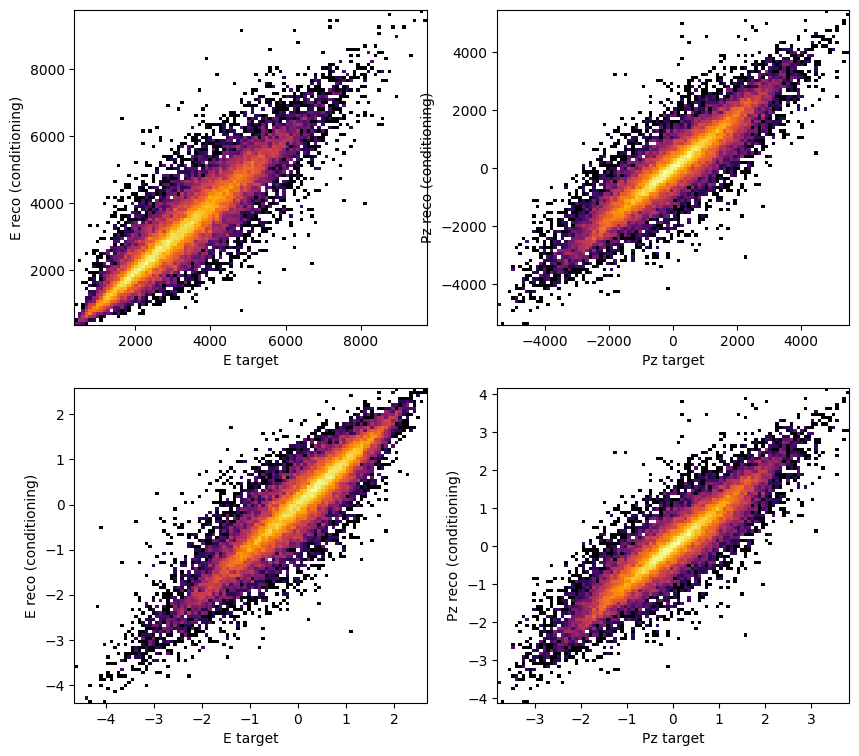

In [4]:
f2, axs = plt.subplots(2, 2, figsize=(10,9))
axs[0][0].hist2d(EcmPz_unscaled[:,0].cpu().numpy(),
           EcmPz_reco_unscaled[:,0].cpu().numpy(),
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
axs[0][0].set_xlabel("E target")
axs[0][0].set_ylabel("E reco (conditioning)")

axs[0][1].hist2d(EcmPz_unscaled[:,1].cpu().numpy(),
           EcmPz_reco_unscaled[:,1].cpu().numpy(),
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
axs[0][1].set_xlabel("Pz target")
axs[0][1].set_ylabel("Pz reco (conditioning)")

axs[1][0].hist2d(EcmPz[:,0].cpu().numpy(),
           EcmPz_reco[:,0].cpu().numpy(),
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
axs[1][0].set_xlabel("E target")
axs[1][0].set_ylabel("E reco (conditioning)")

axs[1][1].hist2d(EcmPz[:,1].cpu().numpy(),
           EcmPz_reco[:,1].cpu().numpy(),
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
axs[1][1].set_xlabel("Pz target")
axs[1][1].set_ylabel("Pz reco (conditioning)")



We want now to learn the conditional probability of the generator Ecm and Pz of the event given the reconstructed total energy and Pz from the jets and leptons in the event.

As show above the two features are already highly correlated with the correspective reco quantities, but we would like to actually **sample** from the distribution. Given a single reconstructed event
we want the distribution of the E_cm and pz at generator level, in practice the x1 and x2 momentum fractions of the incoming partons. 

We work with the Ecm and Pz features as they are better distributed than the x1 and x2 variables. More gaussian like, the better :)

# Conditional Normalizing Flow

### Flows intro

In [10]:
flow = zuko.flows.MAF(features=2, context=2, 
                      transforms=2, hidden_features=[16, 16], 
                      randperm=True)
flow.to("cuda")

MAF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=16, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=16, out_features=16, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=16, out_features=4, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=16, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=16, out_features=16, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=16, out_features=4, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([2]), scale: torch.Size([2])))
)

In [11]:
def train_flow(model, device, loader, val_loader,  optimizer,  scheduler, epochs):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x1x2, EcmPz, EcmPz_reco, EcmPz_unscaled, EcmPz_reco_unscaled) in enumerate(loader):
            optimizer.zero_grad()

            log_prob = flow(EcmPz_reco).log_prob(EcmPz)
            loss = - log_prob.mean()
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}")
                 
            loss.backward()
            optimizer.step()
           
    
        val_loss = 0.  
        with torch.no_grad():
            for x1x2, EcmPz, EcmPz_reco, EcmPz_unscaled, EcmPz_reco_unscaled in val_loader:
                
               log_prob_val = flow(EcmPz_reco).log_prob(EcmPz)
               val_loss = - log_prob_val.mean()
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)
            
        print(f"End of epoch {epoch}")
    return model

In [12]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.05) 
num_epochs = 5

flow_trained = train_flow(flow, "cuda", dataloader_train, dataloader_val, optimizer, scheduler, num_epochs)

epoch 0, step 0, Loss: 3.0259
epoch 0, step 100, Loss: 0.8714
epoch 0, step 200, Loss: 0.7469
epoch 0, Validation Loss: 0.6939
End of epoch 0
epoch 1, step 0, Loss: 0.6572
epoch 1, step 100, Loss: 0.6473
epoch 1, step 200, Loss: 0.6311
epoch 1, Validation Loss: 0.6819
End of epoch 1
epoch 2, step 0, Loss: 0.6040
epoch 2, step 100, Loss: 0.6855
epoch 2, step 200, Loss: 0.6171
epoch 2, Validation Loss: 0.6848
End of epoch 2
epoch 3, step 0, Loss: 0.6410
epoch 3, step 100, Loss: 0.6371
epoch 3, step 200, Loss: 0.7070
epoch 3, Validation Loss: 0.6488
End of epoch 3
epoch 4, step 0, Loss: 0.6169
epoch 4, step 100, Loss: 0.6879


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f520bedc990>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


epoch 4, step 200, Loss: 0.6480


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f520bedc990>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


epoch 4, Validation Loss: 0.6947
End of epoch 4


In [31]:
torch.save(flow_trained.state_dict(), "models/flows_ecmpz_v1.pt")

## Validation

The first validation is performed sampling 1 gen level boost for each reco level boost

In [15]:
x1x2, EcmPz, EcmPz_reco, EcmPz_unscaled, EcmPz_reco_unscaled = dataset_train[0:20000]
with torch.no_grad():
    samples = flow(EcmPz_reco).sample((1,))

Text(0.5, 1.0, 'Truth')

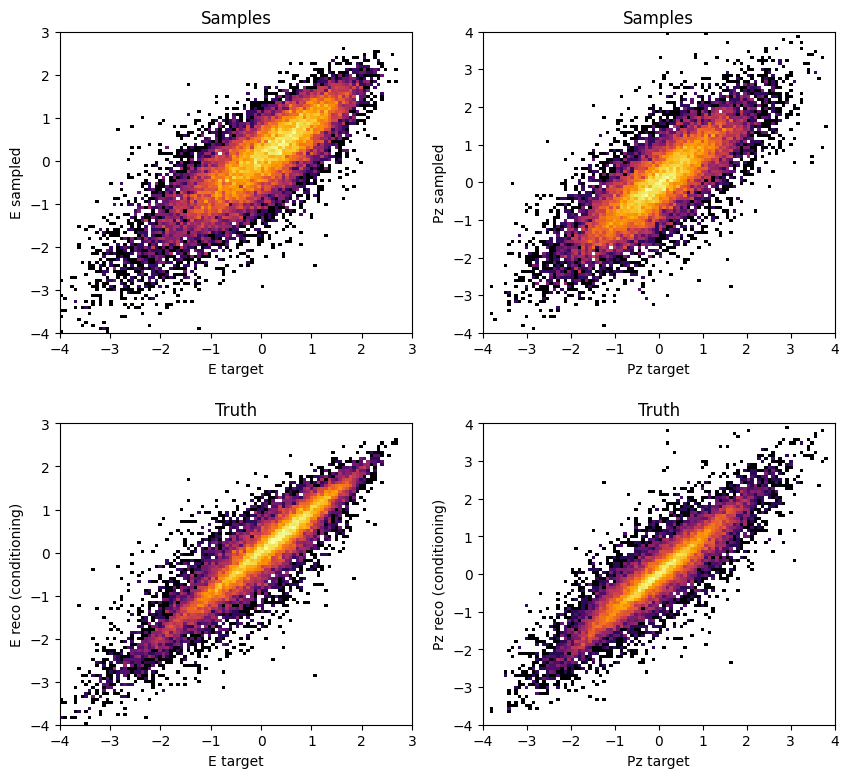

In [16]:
f2, axs = plt.subplots(2, 2, figsize=(10,9))
plt.subplots_adjust(hspace=0.3)
axs[0][0].hist2d(EcmPz[:,0].cpu().numpy(),
               samples[0,:,0].cpu().numpy(),
           bins=[100,100],range=((-4,3),(-4,3)),
                 cmap="inferno", cmin=1, norm=LogNorm());
axs[0][0].set_xlabel("E target")
axs[0][0].set_ylabel("E sampled")
axs[0][0].set_title("Samples")

axs[0][1].hist2d(EcmPz[:,1].cpu().numpy(),
           samples[0,:,1].cpu().cpu().numpy(),
           bins=[100,100],cmap="inferno", 
                 range=((-4,4),(-4,4)),cmin=1, norm=LogNorm());
axs[0][1].set_xlabel("Pz target")
axs[0][1].set_ylabel("Pz sampled")
axs[0][1].set_title("Samples")

axs[1][0].hist2d(EcmPz[:,0].cpu().numpy(),
           EcmPz_reco[:,0].cpu().numpy(),
           bins=[100,100],range=((-4,3),(-4,3)),
                 cmap="inferno", cmin=1, norm=LogNorm());
axs[1][0].set_xlabel("E target")
axs[1][0].set_ylabel("E reco (conditioning)")
axs[1][0].set_title("Truth")

axs[1][1].hist2d(EcmPz[:,1].cpu().numpy(),
           EcmPz_reco[:,1].cpu().numpy(),
           bins=[100,100],range=((-4,4),(-4,4)),
                 cmap="inferno", cmin=1, norm=LogNorm());
axs[1][1].set_xlabel("Pz target")
axs[1][1].set_ylabel("Pz reco (conditioning)")
axs[1][1].set_title("Truth")


### Conditional distributions

In [17]:
scaling = np.load(f"{datafolder}/EcmPz_data_scaling.npy")
def unscale_boost(x):
    out = np.zeros(x.shape)
    out[:,0] =  np.exp(x[:,0]*scaling[0,1]+scaling[0,0]) -1
    out[:,1] =  x[:,1]*scaling[1,1]+scaling[1,0]
    return out

In [24]:
Ecm = 13000.
pz = 600.
Ecm = (np.log(Ecm +1)-scaling[0, 0])/scaling[0,1]
pz = (pz -scaling[1, 0])/scaling[1,1]

with torch.no_grad():
    reco = torch.tensor([Ecm, pz], dtype=torch.float32, device="cuda")
    samples = flow(reco).sample((20000,)).cpu().numpy()
    
samples_unscaled = unscale_boost(samples)
x1 = (samples_unscaled[:,0] + samples_unscaled[:,1])/(6500*2)
x2 = x1 - samples_unscaled[:,1]/6500 

Text(0, 0.5, 'x2')

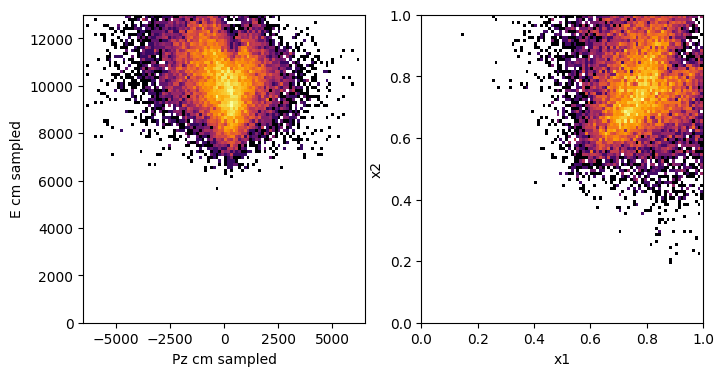

In [25]:
f, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist2d(samples_unscaled[:, 1], samples_unscaled[:, 0], 
              bins=[100,100],range=((-6500, 6500),(0, 13000)),
                 cmap="inferno", cmin=1, norm=LogNorm());
axs[0].set_ylabel("E cm sampled")
axs[0].set_xlabel("Pz cm sampled")

axs[1].hist2d(x1, x2, bins=[100,100],range=((0,1),(0,1)),
                 cmap="inferno", cmin=1, norm=LogNorm());
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")